In [1]:
import matplotlib.pyplot as plt
# Import tensorflow for [`tf.data`](https://www.tensorflow.org/api_docs/python/tf/data) and its preprocessing map functions
import tensorflow as tf
import tensorflow_datasets as tfds
import keras
import keras_cv
from tensorflow.keras.utils import to_categorical
import pathlib
from tensorflow.keras import layers,Input, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import numpy as np

C:\Users\bruno\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
BatchSize = 48
height = 227
width = 227
AUTOTUNE = tf.data.AUTOTUNE

Found 4408 files belonging to 5 classes.
Found 549 files belonging to 5 classes.
Found 556 files belonging to 5 classes.
['Broken soybeans' 'Immature soybeans' 'Intact soybeans'
 'Skin-damaged soybeans' 'Spotted soybeans']


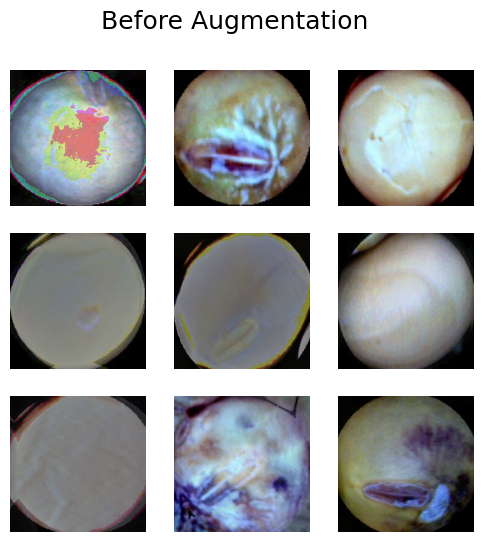

In [16]:


# Load datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'Soja/train',
    image_size=(227, 227),
    batch_size=BatchSize,
    label_mode='int'  # We will convert these labels to one-hot encoding
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'Soja/val',
    image_size=(227, 227),
    batch_size=BatchSize,
    label_mode='int'
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'Soja/test',
    image_size=(227, 227),
    batch_size=BatchSize,
    label_mode='int'
)

# One-hot encode the labels
def one_hot_encode_labels(dataset):
    # Get the number of classes from dataset
    num_classes = len(dataset.class_names)
    
    # Map to one-hot encoded labels
    def encode(image, label):
        return image, to_categorical(label, num_classes)
    
    return dataset.map(encode)

train_ds = one_hot_encode_labels(train_ds)
val_ds = one_hot_encode_labels(val_ds)
test_ds = one_hot_encode_labels(test_ds)

# Apply CutMix
cutmix = keras_cv.layers.CutMix()
augmix = keras_cv.layers.AugMix(
    value_range=[0,255]
)

def apply_cutmix(images, labels):
    return cutmix({"images": images, "labels": labels})
def apply_augmix(images,labels):
    return augmix({"images": images, "labels": labels})
train_ds = train_ds.map(apply_augmix)
data_dir = pathlib.Path("Soja/train")
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)
def visualize_dataset(dataset, title):
    plt.figure(figsize=(6, 6)).suptitle(title, fontsize=18)
    for i, samples in enumerate(iter(dataset.take(9))):
        images = samples["images"]
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[0].numpy().astype("uint8"))
        plt.axis("off")
    plt.show()


visualize_dataset(train_ds, title="Before Augmentation")

def preprocess_for_model(inputs):
    images, labels = inputs["images"], inputs["labels"]
    images = tf.cast(images, tf.float32)
    return images, labels

In [17]:

train_ds = train_ds.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)


In [5]:
# The CONV block
# The CONV block
def Conv(input_layer,filters,k_size, stride, padding):
    x = layers.Conv2D(filters = filters, kernel_size=k_size, strides=stride, padding=padding,activation=None)(input_layer)
    x = layers.PReLU()(x)
    output = layers.BatchNormalization()(x)
    return output
def inception_module(x,f1,f2_in,f2_out,f3_in,f3_out,f4_out):
    # 1x1 branch
    conv1 = layers.Conv2D(f1, (1,1), padding='same', strides = (1,1), activation='relu')(x)
    # 3x3 branch
    conv3 = layers.Conv2D(f2_in, (1,1), padding='same', activation='relu')(x)
    conv3 = layers.Conv2D(f2_out, (3,3), padding='same',activation='relu')(conv3)
    # 5x5 branch
    conv5 = layers.Conv2D(f3_in, (1,1), padding='same', activation='relu')(x)
    conv5 = layers.Conv2D(f3_out, (5,5), padding='same',activation='relu')(conv5)
    # max pooling branch
    pool = layers.MaxPooling2D((3,3),strides=(1,1),padding='same')(x)
    pool = layers.Conv2D(f4_out,(1,1),padding='same',activation='relu')(pool)
    # concatenate the branches
    output = layers.concatenate([conv1,conv3,conv5,pool], axis=-1)
    return output

def residual_block(x):
    x_inp = x
    
    x = inception_module(x,f1=64, f2_in=128, f2_out=128, f3_in=32, f3_out=64, f4_out=32)
    x = inception_module(x,f1=64, f2_in=128, f2_out=128, f3_in=32, f3_out=64, f4_out=32)
    if x.shape[-1] != x_inp.shape[-1]:
        x_inp = layers.Conv2D(x.shape[-1],(1,1),padding='same', activation='relu', kernel_initializer='he_normal')(x)
        print(x_inp.shape[-1])
    layer_out = layers.add([x,x_inp])
    layer_out = layers.Activation('relu')(layer_out)
    return layer_out

def residual_block_conv(x):
    x_inp = x
    x_inp = layers.Conv2D(288, (3,3), strides=(2,2), padding='same', activation='relu')(x)
    
    x = inception_module(x,f1=64, f2_in=128, f2_out=128, f3_in=32, f3_out=64, f4_out=32)
    x = layers.MaxPooling2D((2,2),strides=(2,2),padding='same')(x)
    x = inception_module(x,f1=64, f2_in=128, f2_out=128, f3_in=32, f3_out=64, f4_out=32)
    if x.shape[-1] != x_inp.shape[-1]:
        x_inp = layers.Conv2D(x.shape[-1],(1,1),padding='same', activation='relu', kernel_initializer='he_normal')(x)
        
    layer_out = layers.add([x,x_inp])
    layer_out = layers.Activation('relu')(layer_out)
    return layer_out

def learning_rate_schedule(epoch):
    initial_lr = 0.001  
    drop = 0.95  
    epochs_drop = 5 
    lr = initial_lr * (drop ** (epoch/ epochs_drop))
    return lr

def resize_and_rescale(x):
    x = layers.Resizing(227,227)(x)
    x = layers.Rescaling(1./255)
    return x

def data_augmentation(x):
    x = layers.RandomFlip("horizontal_and_vertical")(x)
    x = layers.RandomRotation(0.2)(x)
    return x

In [18]:
input_img = Input(shape=(227, 227, 3))  # Example input shape (224x224 RGB image)
x = data_augmentation(input_img)
x = Conv(input_layer=x, filters=8,k_size=(3,3),stride=(2,2), padding='valid')
x = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid')(x)
x = Conv(input_layer=x, filters=16,k_size=(1,1),stride=(2,2), padding='valid')
x = layers.MaxPooling2D(pool_size=(2,2), strides=(1,1), padding='same')(x)
x = residual_block(x)
x = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same')(x)
x = residual_block_conv(x)
x = layers.AveragePooling2D((1,1))(x)
x = layers.Flatten()(x)
x = layers.Dense(64)(x)
x = layers.Dense(len(class_names))(x)

# Create the model
model = Model(inputs=input_img, outputs=x)

# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate_schedule(0)), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(learning_rate_schedule)
# Print the model summary
model.summary()

#put data augmentation

288


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 227, 227,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip_1       │ (None, 227, 227,  │          0 │ input_layer_1[0]… │
│ (RandomFlip)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_rotation_1   │ (None, 227, 227,  │          0 │ random_flip_1[0]… │
│ (RandomRotation)    │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 113, 113,  │        224 │ random_rotation_… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_2 (PReLU)   │ (None, 113, 113,  │    102,152 │ conv2d_28[0][0]   │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 113, 113,  │         32 │ p_re_lu_2[0][0]   │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 56, 56, 8) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 28, 28,    │        144 │ max_pooling2d_8[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_3 (PReLU)   │ (None, 28, 28,    │     12,544 │ conv2d_29[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │         64 │ p_re_lu_3[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 28, 28,    │      2,176 │ max_pooling2d_9[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 28, 28,    │        544 │ max_pooling2d_9[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 28, 28,    │          0 │ max_pooling2d_9[… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 28, 28,    │      1,088 │ max_pooling2d_9[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 28, 28,    │    147,584 │ conv2d_31[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 28, 28,    │     51,264 │ conv2d_33[0][0] 

 Total params: 2,870,429 (10.95 MB)

 Trainable params: 2,870,381 (10.95 MB)

 Non-trainable params: 48 (192.00 B)

In [19]:
epochs = 120


history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[lr_scheduler]
)

Epoch 1/120
92/92 ━━━━━━━━━━━━━━━━━━━━ 101s 989ms/step - accuracy: 0.2717 - loss: 4.9455 - val_accuracy: 0.3279 - val_loss: 1.4684 - learning_rate: 0.0010
Epoch 2/120
92/92 ━━━━━━━━━━━━━━━━━━━━ 91s 978ms/step - accuracy: 0.4096 - loss: 1.3821 - val_accuracy: 0.4317 - val_loss: 1.3198 - learning_rate: 9.8979e-04
Epoch 3/120
92/92 ━━━━━━━━━━━━━━━━━━━━ 92s 990ms/step - accuracy: 0.5477 - loss: 1.1560 - val_accuracy: 0.4699 - val_loss: 1.4410 - learning_rate: 9.7969e-04
Epoch 4/120
92/92 ━━━━━━━━━━━━━━━━━━━━ 91s 981ms/step - accuracy: 0.6238 - loss: 1.0296 - val_accuracy: 0.6758 - val_loss: 0.7949 - learning_rate: 9.6969e-04
Epoch 5/120
92/92 ━━━━━━━━━━━━━━━━━━━━ 93s 994ms/step - accuracy: 0.6578 - loss: 0.8961 - val_accuracy: 0.6448 - val_loss: 0.9096 - learning_rate: 9.5980e-04
Epoch 6/120
92/92 ━━━━━━━━━━━━━━━━━━━━ 91s 974ms/step - accuracy: 0.6898 - loss: 0.8261 - val_accuracy: 0.6903 - val_loss: 0.7958 - learning_rate: 9.5000e-04
Epoch 7/120
92/92 ━━━━━━━━━━━━━━━━━━━━ 91s 981ms/step -

In [20]:
model.evaluate(test_ds)

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - accuracy: 0.9011 - loss: 0.3073


[0.3161453604698181, 0.9010791182518005]

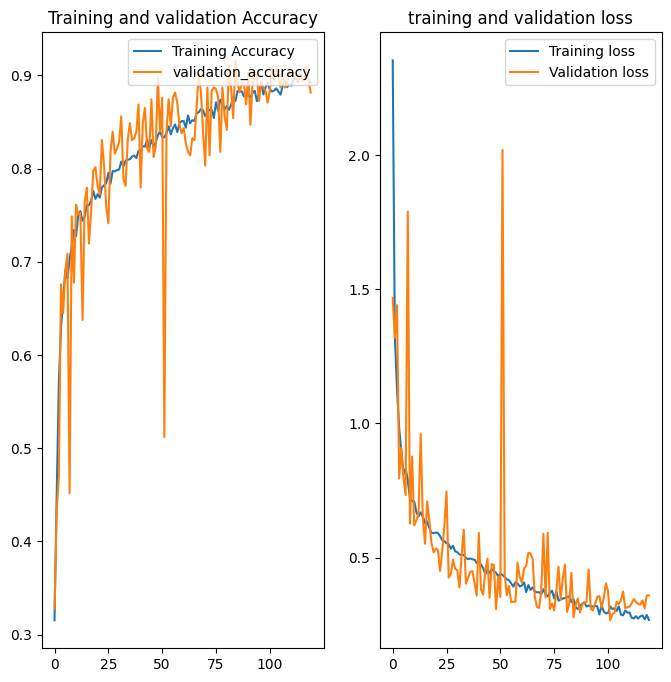

In [21]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range,val_acc,label="validation_accuracy")
plt.legend(loc="upper right")
plt.title("Training and validation Accuracy")

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label="Training loss")
plt.plot(epochs_range, val_loss, label="Validation loss")
plt.legend(loc="upper right")
plt.title("training and validation loss")
plt.show()